# Handle Cold Start Users using Association Rules
Cold-Start are those who have a limited or do not have any historical behaviors yet. Since this is a common problem that most of business will face, I will try to handle those users using association rules, apriori algorithm. With the apriori algorithm, we'll get the association between two products. This association, will be useful for new users to be recommended to a some products they might like.

In this notebook, I use an IMDB dataset that consists of 25Mio reviews. Yes, apriori algorithm costs high in computing, so it will give OOM if you tried to feed those data to the algorithms. So I only use Comedy genre movie that has 13K movieIds, FYI Comedy is the third biggest genre in the dataset after drama(80%) and romance. Filtering only comedy movies, I got 2.6 Mio left to be processed.

The processing consists of several steps.
1. Split the data into train and test and create dummy cold start users for test dataset (you'll see what I mean).
2. Feed the train dataset into the apriori algorithms
3. The apriori algorithms will return A->B, match those result to the test dataset
4. Evaluate with Recall metric

In [231]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
from apyori import apriori
import math

In [232]:
ratings = pd.read_csv('/home/woi/project/cold-start users/archive/ratings.csv')
ratings.loc[:, "date"] = pd.to_datetime(ratings.timestamp, unit='s')

In [233]:
includeMvsId = np.load('../log/animationId.npy', allow_pickle=True)
includeMvsId = [int(ele) for ele in includeMvsId]
ratings = ratings[ratings['movieId'].isin(includeMvsId)]
ratings = ratings[ratings.rating>=3]
ratings['ones'] = 1

## Split Train Test

In this part we will split the data into test with 20% users and train with 80%

In [234]:
usersInfo = ratings.groupby('userId')['movieId'].nunique().reset_index()
test_users = np.random.choice(usersInfo[(usersInfo['movieId']>1) & (usersInfo['movieId']<30)]['userId'], size=int(len(usersInfo)*0.2))
np.save(open('../log/test_users.npy', 'wb'), test_users)

In [235]:
train = ratings[~ratings['userId'].isin(test_users)]
test = ratings[ratings['userId'].isin(test_users)]

In [236]:
new_test = test.sort_values('date').groupby('userId').agg(movie_list=('movieId',list)).reset_index()
new_test['len'] = new_test['movie_list'].apply(len)


# Forcing them to be cold-start users that only review 1 - 5 movies
new_test['X'] = new_test['movie_list'].apply(lambda x: x[:math.ceil(len(x)*0.1)])
new_test['y'] = new_test['movie_list'].apply(lambda x: x[math.ceil(len(x)*0.1):])

In [237]:
new_test

,userId,movie_list,len,X,y
0,1,"[858, 2959, 1968, 4226]",4,[858],"[2959, 1968, 4226]"
1,10,"[150, 344, 349, 165, 457]",5,[150],"[344, 349, 165, 457]"
2,16,"[2959, 44191, 4011, 1732, 2105, 2455, 316, 198...",13,"[2959, 44191]","[4011, 1732, 2105, 2455, 316, 198, 480, 8985, ..."
3,20,"[936, 2959, 5618, 46578, 919, 8464, 1732, 4697...",27,"[936, 2959, 5618]","[46578, 919, 8464, 1732, 46976, 480, 4728, 410..."
4,22,"[342, 457, 1610]",3,[342],"[457, 1610]"
...,...,...,...,...,...
41046,270855,"[858, 1968]",2,[858],[1968]
41047,270879,"[3082, 457, 150, 344, 165, 339, 1721, 4896, 30...",23,"[3082, 457, 150]","[344, 165, 339, 1721, 4896, 3053, 2294, 480, 1..."
41048,270880,"[920, 1721]",2,[920],[1721]
41049,270881,"[306, 1968, 308]",3,[306],"[1968, 308]"


## Feed the data to the apriori algorithm

In [238]:
itemusers = train.groupby('userId').agg({'movieId':list}).reset_index()['movieId']

In [239]:
association_rules = apriori(itemusers, min_support=0.025, min_confidence=0.2, min_lift=3, min_length=2)
association_results = list(association_rules)

In [240]:
result = {'item_base':[], 'item_add':[], 'support':[], 'confidence':[], 'lift':[]}
for item in association_results:
    pair = item[0]
    items = [x for x in pair]
    result['item_base'].append(items[0])
    result['item_add'].append(items[1])
    result['support'].append(item[1])
    result['confidence'].append(item[2][0][2])
    result['lift'].append(item[2][0][3])

In [241]:
result = pd.DataFrame(result)

In [242]:
res = result.sort_values('confidence', ascending=False).groupby('item_base').agg({'item_add':list}).reset_index()
res2 = res.T
res2.columns = res['item_base']
res2 = res2.loc['item_add']
test = new_test.explode('X')

In [252]:
# This is how the map look like.

res2

item_base
165               [457, 457, 457, 350, 457, 457, 150, 457]
196                                             [316, 165]
236                                                  [349]
292      [349, 316, 165, 349, 300, 349, 150, 350, 150, ...
300      [349, 349, 316, 508, 150, 509, 508, 350, 349, ...
                               ...                        
44191    [8874, 858, 2028, 4011, 8961, 5618, 46578, 422...
44555                                               [2959]
46578    [858, 2028, 8874, 858, 44191, 4226, 8874, 858,...
46976                                         [2959, 4226]
74458     [2959, 4226, 858, 2028, 44191, 4011, 4011, 4226]
Name: item_add, Length: 66, dtype: object

In [256]:
comparison = test.merge(result, left_on='X', right_on='item_base', how='left')
comparison = comparison.groupby('userId').agg(item_add=('item_add',list), movie_list=('y',min)).reset_index()
comparison['item_add'] = comparison['item_add'].apply(set).apply(list).apply(lambda x: [x[i] for i in range(len(x)) if x[i]==x[i] ])

In [257]:
#  Movie list is the Y while item_add is the Y_hat or the movies we're trying to predict.
#  Those list will be scored by Recall to evaluate how good is our model to predict what the users like

comparison

,userId,item_add,movie_list
0,1,"[1732.0, 165.0, 1610.0, 4011.0, 2028.0, 5995.0...","[2959, 1968, 4226]"
1,10,[],"[344, 349, 165, 457]"
2,16,"[8961.0, 4226.0, 1732.0, 74458.0, 457.0, 778.0...","[4011, 1732, 2105, 2455, 316, 198, 480, 8985, ..."
3,20,"[8961.0, 4226.0, 1732.0, 457.0, 778.0, 1961.0,...","[46578, 919, 8464, 1732, 46976, 480, 4728, 410..."
4,22,[],"[457, 1610]"
...,...,...,...
41046,270855,"[1732.0, 165.0, 1610.0, 4011.0, 2028.0, 5995.0...",[1968]
41047,270879,"[8961.0, 4226.0, 2058.0, 778.0, 150.0, 410.0, ...","[344, 165, 339, 1721, 4896, 3053, 2294, 480, 1..."
41048,270880,"[1961.0, 858.0, 750.0, 919.0]",[1721]
41049,270881,[],"[1968, 308]"


## Calculate the Recall
As we know, recall formula equals to TP/(TP+FN) where TP is the true prediction and FN is the false prediction. In this case, we can divide the true prediction with the length of predction that the algorithm made. From this score, we know how much the algorithm can understand our users behavior.

In [259]:
comparison['item_add'] = comparison['item_add'].apply(set).apply(list)
comparison['movie_list'] = comparison['movie_list'].apply(set).apply(list)
comparison['intersection_len'] = [len(set(rec).intersection(movie)) for rec,movie in zip(comparison['item_add'], comparison['movie_list'])]
comparison['pred_len'] = comparison['item_add'].apply(len)
comparison['recall'] = comparison['intersection_len']/comparison['pred_len']

In [260]:
comparison.head(20)

,userId,item_add,movie_list,intersection_len,pred_len,recall
0,1,"[1732.0, 165.0, 1610.0, 4011.0, 2028.0, 5995.0...","[1968, 4226, 2959]",0,13,0.000000
1,10,[],"[344, 457, 349, 165]",0,0,NaN
2,16,"[8961.0, 4226.0, 1732.0, 457.0, 778.0, 1961.0,...","[480, 4226, 1732, 198, 4011, 8464, 2193, 2455,...",3,17,0.176471
3,20,"[8961.0, 4226.0, 1732.0, 457.0, 778.0, 1961.0,...","[46976, 6283, 911, 8464, 150, 919, 920, 410, 2...",4,14,0.285714
4,22,[],"[457, 1610]",0,0,NaN
5,31,[],"[1377, 2018, 2294]",0,0,NaN
6,43,"[8961.0, 4226.0, 4034.0, 1732.0, 165.0, 6373.0...","[8961, 3082, 2959, 788, 150, 919, 158, 2078, 4...",3,17,0.176471
7,53,"[8961.0, 4226.0, 778.0, 2321.0, 150.0, 919.0, ...","[4226, 838, 3083, 2539, 1613, 6382, 2610, 2611...",1,19,0.052632
8,54,[919.0],"[480, 928, 4034, 5, 1544, 3784, 919, 920]",1,1,1.000000
9,57,[],"[1262, 2294]",0,0,NaN


## Result
We got 0.15 or 15% correct. Is it good or bad? Well, we need a comparison.

In [246]:
print(f"% of users who don't get recommendation: {len(comparison[comparison['recall'].isna()])/len(comparison) * 100}%")

% of users who don't get recommendation: 38.63243282745853%


In [247]:
comparison['recall'].describe()

count    25192.000000
mean         0.151967
std          0.192365
min          0.000000
25%          0.000000
50%          0.086957
75%          0.230769
max          1.000000
Name: recall, dtype: float64

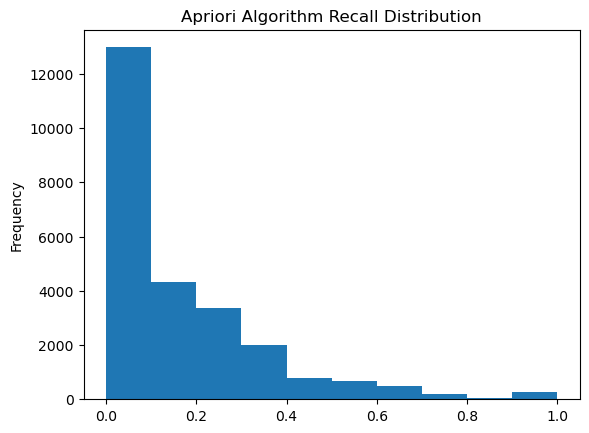

In [264]:
comparison.recall.plot(kind='hist')
plt.title("Apriori Algorithm Recall Distribution")
plt.show()

## Comparison
In this section, I'd try to compare the Apriori Algorithm to random and popularity-based recommendation.

### Popluarity-Based Recommendation
In this case, we only got 0.01 Recall score which is much worse than our apriori algorithm.

In [266]:
# Creating the top 20 most review movies based on the train dataset.

train = ratings[~ratings['userId'].isin(test_users)]
test = ratings[ratings['userId'].isin(test_users)]

test = test.groupby('userId').agg(movie_list=('movieId',list)).reset_index()
test.loc[:,'idx'] = 1

In [267]:
popular_list = list(train.groupby('movieId')['userId'].nunique().index[:10])
test['popular_list'] = [popular_list]*len(test)

In [268]:
# I am to lazy to change the variable name :P
comparison = test.copy()
comparison['intersection_len'] = [len(set(rec).intersection(movie)) for rec,movie in zip(comparison['popular_list'], comparison['movie_list'])]
comparison['len'] = comparison['popular_list'].apply(len)
comparison['recall'] = comparison['intersection_len']/comparison['len']

In [269]:
comparison['recall'].describe()

count    41051.000000
mean         0.011807
std          0.040330
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.500000
Name: recall, dtype: float64

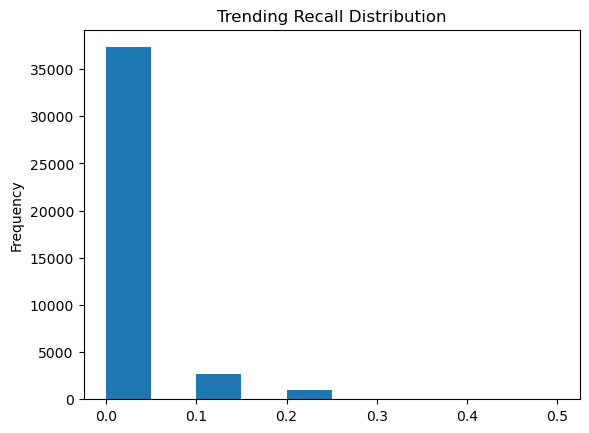

In [270]:
comparison.recall.plot(kind='hist')
plt.title("Trending Recall Distribution")
plt.show()

### Random-based recommendation
As we can see, random recommendation is much much much worse as it only got 0.004 correct prediction.

In [272]:
# Creating the top 20 most review movies based on the train dataset.

train = ratings[~ratings['userId'].isin(test_users)]
test = ratings[ratings['userId'].isin(test_users)]

test = test.groupby('userId').agg(movie_list=('movieId',list)).reset_index()
test.loc[:,'idx'] = 1

In [273]:
movies_list = train['movieId'].unique()

In [274]:
# Generating 10 random movieID for each user
test['random_list'] = test['movie_list'].apply(lambda x: np.random.choice(movies_list, size=10))

In [275]:
comparison = test.copy()
comparison['intersection_len'] = [len(set(rec).intersection(movie)) for rec,movie in zip(comparison['random_list'], comparison['movie_list'])]
comparison['len'] = comparison['random_list'].apply(len)
comparison['recall'] = comparison['intersection_len']/comparison['len']

In [276]:
comparison['recall'].describe()

count    41051.000000
mean         0.004034
std          0.020237
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.200000
Name: recall, dtype: float64

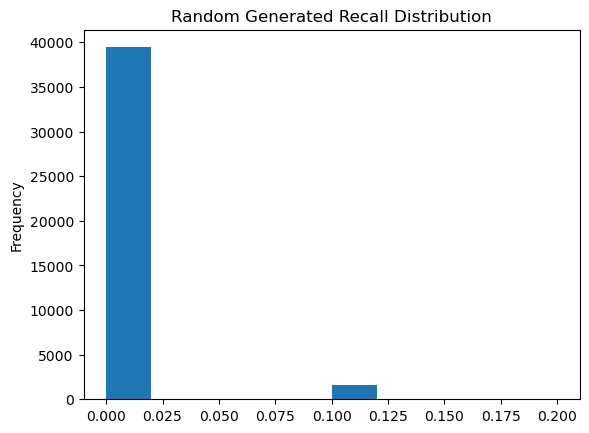

In [277]:
comparison.recall.plot(kind='hist')
plt.title("Random Generated Recall Distribution")
plt.show()

# Conclusion

1. Yes we can handle the cold-start users by recommending them using association rules.
2. The recommendation of apriori algorithm is much better than recommending users trending or random movies
3. There are ~30% users who won't get recommendations since the algorithm couldn't find the association of those reviewed movies

Anyway, how did I get this idea?
# References
1. Practical Recommender Systems (https://www.manning.com/books/practical-recommender-systems)
Anything that mentioned in this notebook
2. Apriori Algorithm (https://medium.com/analytics-vidhya/apriori-algorithm-in-association-rule-learning-9287fe17e944?source=-----9287fe17e944----3----------------------------)
3. Recall (https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2)
4. How to know your model is good? (https://www.coursera.org/learn/machine-learning-projects)